The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3
!pip install "setuptools==66"
!pip install "wheel==0.38.4"
!pip install "gym==0.21.0"


# Value Iteration
:label:`sec_valueiter`

In this section we will discuss how to pick the best action for the robot at each state to maximize the *return* of the trajectory. We will describe an algorithm called Value Iteration and implement it for a simulated robot that travels over a frozen lake.

## Stochastic Policy

A stochastic policy denoted as $\pi(a \mid s)$ (policy for short) is a conditional distribution over the actions $a \in \mathcal{A}$ given the state $s \in \mathcal{S}$, $\pi(a \mid s) \equiv P(a \mid s)$. As an example, if the robot has four actions $\mathcal{A}=$ {go left, go down, go right, go up}. The policy at a state $s \in \mathcal{S}$ for such a set of actions $\mathcal{A}$ is a categorical distribution where the probabilities of the four actions could be $[0.4, 0.2, 0.1, 0.3]$; at some other state $s' \in \mathcal{S}$ the probabilities $\pi(a \mid s')$ of the same four actions could be $[0.1, 0.1, 0.2, 0.6]$. Note that we should have $\sum_a \pi(a \mid s) = 1$ for any state $s$. A deterministic policy is a special case of a stochastic policy in that the distribution $\pi(a \mid s)$ only gives non-zero probability to one particular action, e.g., $[1, 0, 0, 0]$ for our example with four actions.

To make the notation less cumbersome, we will often write $\pi(s)$ as the conditional distribution instead of $\pi(a \mid s)$.

## Value Function

Imagine now that the robot starts at a state $s_0$ and at each time instant, it first samples an action from the policy $a_t \sim \pi(s_t)$ and takes this action to result in the next state $s_{t+1}$. The trajectory $\tau = (s_0, a_0, r_0, s_1, a_1, r_1, \ldots)$, can be different depending upon which particular action $a_t$ is sampled at intermediate instants. We define the average *return* $R(\tau) = \sum_{t=0}^\infty \gamma^t r(s_t, a_t)$ of all such trajectories
$$V^\pi(s_0) = E_{a_t \sim \pi(s_t)} \Big[ R(\tau) \Big] = E_{a_t \sim \pi(s_t)} \Big[ \sum_{t=0}^\infty \gamma^t r(s_t, a_t) \Big],$$

where $s_{t+1} \sim P(s_{t+1} \mid s_t, a_t)$ is the next state of the robot and $r(s_t, a_t)$ is the instantaneous reward obtained by taking action $a_t$ in state $s_t$ at time $t$. This is called the "value function" for the policy $\pi$. In simple words, the value of a state $s_0$ for a policy $\pi$, denoted by $V^\pi(s_0)$, is the expected $\gamma$-discounted *return* obtained by the robot if it begins at state $s_0$ and takes actions from the policy $\pi$ at each time instant.

We next break down the trajectory into two stages (i) the first stage which corresponds to $s_0 \to s_1$ upon taking the action $a_0$, and (ii) a second stage which is the trajectory $\tau' = (s_1, a_1, r_1, \ldots)$ thereafter. The key idea behind all algorithms in reinforcement learning is that the value of state $s_0$ can be written as the average reward obtained in the first stage and the value function averaged over all possible next states $s_1$. This is quite intuitive and arises from our Markov assumption: the average return from the current state is the sum of the average return from the next state and the average reward of going to the next state. Mathematically, we write the two stages as

$$V^\pi(s_0) = r(s_0, a_0) + \gamma\ E_{a_0 \sim \pi(s_0)} \Big[ E_{s_1 \sim P(s_1 \mid s_0, a_0)} \Big[ V^\pi(s_1) \Big] \Big].$$
:eqlabel:`eq_dynamic_programming`

This decomposition is very powerful: it is the foundation of the principle of dynamic programming upon which all reinforcement learning algorithms are based. Notice that the second stage gets two expectations, one over the choices of the action $a_0$ taken in the first stage using the stochastic policy and another over the possible states $s_1$ obtained from the chosen action. We can write :eqref:`eq_dynamic_programming` using the transition probabilities in the Markov decision process (MDP) as

$$V^\pi(s) = \sum_{a \in \mathcal{A}} \pi(a \mid s) \Big[ r(s,  a) + \gamma\  \sum_{s' \in \mathcal{S}} P(s' \mid s, a) V^\pi(s') \Big];\ \textrm{for all } s \in \mathcal{S}.$$
:eqlabel:`eq_dynamic_programming_val`

An important thing to notice here is that the above identity holds for all states $s \in \mathcal{S}$ because we can think of any trajectory that begins at that state and break down the trajectory into two stages.

## Action-Value Function

In implementations, it is often useful to maintain a quantity called the "action value" function which is a closely related quantity to the value function. This is defined to be the average *return* of a trajectory that begins at $s_0$ but when the action of the first stage is fixed to be $a_0$

$$Q^\pi(s_0, a_0) = r(s_0, a_0) + E_{a_t \sim \pi(s_t)} \Big[ \sum_{t=1}^\infty \gamma^t r(s_t, a_t) \Big],$$

note that the summation inside the expectation is from $t=1,\ldots, \infty$ because the reward of the first stage is fixed in this case. We can again break down the trajectory into two parts and write

$$Q^\pi(s, a) = r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s' \mid s, a) \sum_{a' \in \mathcal{A}} \pi(a' \mid s')\ Q^\pi(s', a');\ \textrm{ for all } s \in \mathcal{S}, a \in \mathcal{A}.$$
:eqlabel:`eq_dynamic_programming_q`

This version is the analog of :eqref:`eq_dynamic_programming_val` for the action value function.

## Optimal Stochastic Policy

Both the value function and the action-value function depend upon the policy that the robot chooses. We will next think of the "optimal policy" that achieves the maximal average *return*
$$\pi^* = \underset{\pi}{\mathrm{argmax}} V^\pi(s_0).$$

Of all possible stochastic policies that the robot could have taken, the optimal policy $\pi^*$  achieves the largest average discounted *return* for trajectories starting from state $s_0$. Let us denote the value function and the action-value function of the optimal policy as $V^* \equiv V^{\pi^*}$ and $Q^* \equiv Q^{\pi^*}$.

Let us observe that for a deterministic policy where there is only one action that is possible under the policy at any given state. This gives us

$$\pi^*(s) = \underset{a \in \mathcal{A}}{\mathrm{argmax}} \Big[ r(s, a) + \gamma \sum_{s' \in \mathcal{S}} P(s' \mid s, a)\ V^*(s') \Big].$$

A good mnemonic to remember this is that the optimal action at state $s$ (for a deterministic policy) is the one that maximizes the sum of reward $r(s, a)$ from the first stage and the average *return* of the trajectories starting from the next sate $s'$, averaged over all possible next states $s'$ from the second stage.

## Principle of Dynamic Programming

Our developement in the previous section in :eqref:`eq_dynamic_programming` or :eqref:`eq_dynamic_programming_q` can be turned into an algorithm to compute the optimal value function $V^*$ or the action-value function $Q^*$, respectively. Observe that
$$ V^*(s) = \sum_{a \in \mathcal{A}} \pi^*(a \mid s) \Big[ r(s,  a) + \gamma\  \sum_{s' \in \mathcal{S}} P(s' \mid s, a) V^*(s') \Big];\ \textrm{for all } s \in \mathcal{S}.$$

For a deterministic optimal policy $\pi^*$, since there is only one action that can be taken at state $s$, we can also write 

$$V^*(s) = \mathrm{argmax}_{a \in \mathcal{A}} \Big\{ r(s,a) + \gamma \sum_{s' \in \mathcal{S}} P(s' \mid s, a) V^*(s') \Big\}$$

for all states $s \in \mathcal{S}$. This identity is called the "principle of dynamic programming" :cite:`BellmanDPPaper,BellmanDPBook`. It was formulated by Richard Bellman in 1950s and we can remember it as "the remainder of an optimal trajectory is also optimal".

## Value Iteration

We can turn the principle of dynamic programming into an algorithm for finding the optimal value function called value iteration. The key idea behind value iteration is to think of this identity as a set of constraints that tie together $V^*(s)$ at different states $s \in \mathcal{S}$. We initialize the value function to some arbitrary values $V_0(s)$ for all states $s \in \mathcal{S}$. At the $k^{\textrm{th}}$ iteration, the Value Iteration algorithm updates the value function as

$$V_{k+1}(s) = \max_{a \in \mathcal{A}} \Big\{ r(s,  a) + \gamma\  \sum_{s' \in \mathcal{S}} P(s' \mid s, a) V_k(s') \Big\};\ \textrm{for all } s \in \mathcal{S}.$$

It turns out that as $k \to \infty$ the value function estimated by the Value Iteration algorithm converges to the optimal value function irrespective of the initialization $V_0$,
$$V^*(s) = \lim_{k \to \infty} V_k(s);\ \textrm{for all states } s \in \mathcal{S}.$$

The same Value Iteration algorithm can be equivalently written using the action-value function as
$$Q_{k+1}(s, a) = r(s, a) + \gamma \max_{a' \in \mathcal{A}} \sum_{s' \in \mathcal{S}} P(s' \mid s, a) Q_k (s', a');\ \textrm{ for all } s \in \mathcal{S}, a \in \mathcal{A}.$$

In this case we initialize $Q_0(s, a)$ to some arbitrary values for all $s \in \mathcal{S}$ and $a \in \mathcal{A}$. Again we have $Q^*(s, a) = \lim_{k \to \infty} Q_k(s, a)$ for all $s \in \mathcal{S}$ and $a \in \mathcal{A}$.

## Policy Evaluation

Value Iteration enables us to compute the optimal value function, i.e., $V^{\pi^*}$ of the optimal deterministic policy $\pi^*$. We can also use similar iterative updates to compute the value function associated with any other, potentially stochastic, policy $\pi$. We again initialize $V^\pi_0(s)$ to some arbitrary values for all states $s \in \mathcal{S}$ and at the $k^{\textrm{th}}$ iteration, perform the updates

$$    V^\pi_{k+1}(s) = \sum_{a \in \mathcal{A}} \pi(a \mid s) \Big[ r(s,  a) + \gamma\  \sum_{s' \in \mathcal{S}} P(s' \mid s, a) V^\pi_k(s') \Big];\ \textrm{for all } s \in \mathcal{S}.$$

This algorithm is known as policy evaluation and is useful to compute the value function given the policy. Again, it turns out that as $k \to \infty$ these updates converge to the correct value function irrespective of the initialization $V_0$,

$$V^\pi(s) = \lim_{k \to \infty} V^\pi_k(s);\ \textrm{for all states } s \in \mathcal{S}.$$

The algorithm for computing the action-value function $Q^\pi(s, a)$ of a policy $\pi$ is analogous.

## Implementation of Value Iteration
:label:`subsec_valueitercode`
We next show how to implement Value Iteration for a navigation problem called FrozenLake from [Open AI Gym](https://gym.openai.com). We first need to setup the enviroment as shown in the following code.


In [1]:
%matplotlib inline
import random
import numpy as np
from d2l import torch as d2l

seed = 0  # Random number generator seed
gamma = 0.95  # Discount factor
num_iters = 10  # Number of iterations
random.seed(seed)  # Set the random seed to ensure results can be reproduced
np.random.seed(seed)

# Now set up the environment
env_info = d2l.make_env('FrozenLake-v1', seed=seed)

In the FrozenLake environment, the robot moves on a $4 \times 4$ grid (these are the states) with actions that are "up" ($\uparrow$), "down" ($\rightarrow$), "left" ($\leftarrow$), and "right" ($\rightarrow$). The environment contains a number of holes (H) cells and frozen (F) cells as well as a goal cell (G), all of which are unknown to the robot. To keep the problem simple, we assume the robot has reliable actions, i.e. $P(s' \mid s, a) = 1$ for all $s \in \mathcal{S}, a \in \mathcal{A}$. If the robot reaches the goal, the trial ends and the robot receives a reward of $1$ irrespective of the action; the reward at any other state is $0$ for all actions. The objective of the robot is to learn a policy that reaches the goal location (G) from a given start location (S) (this is $s_0$) to maximize the *return*.

The following function implements Value Iteration, where `env_info` contains MDP and environment related information and `gamma` is the discount factor:


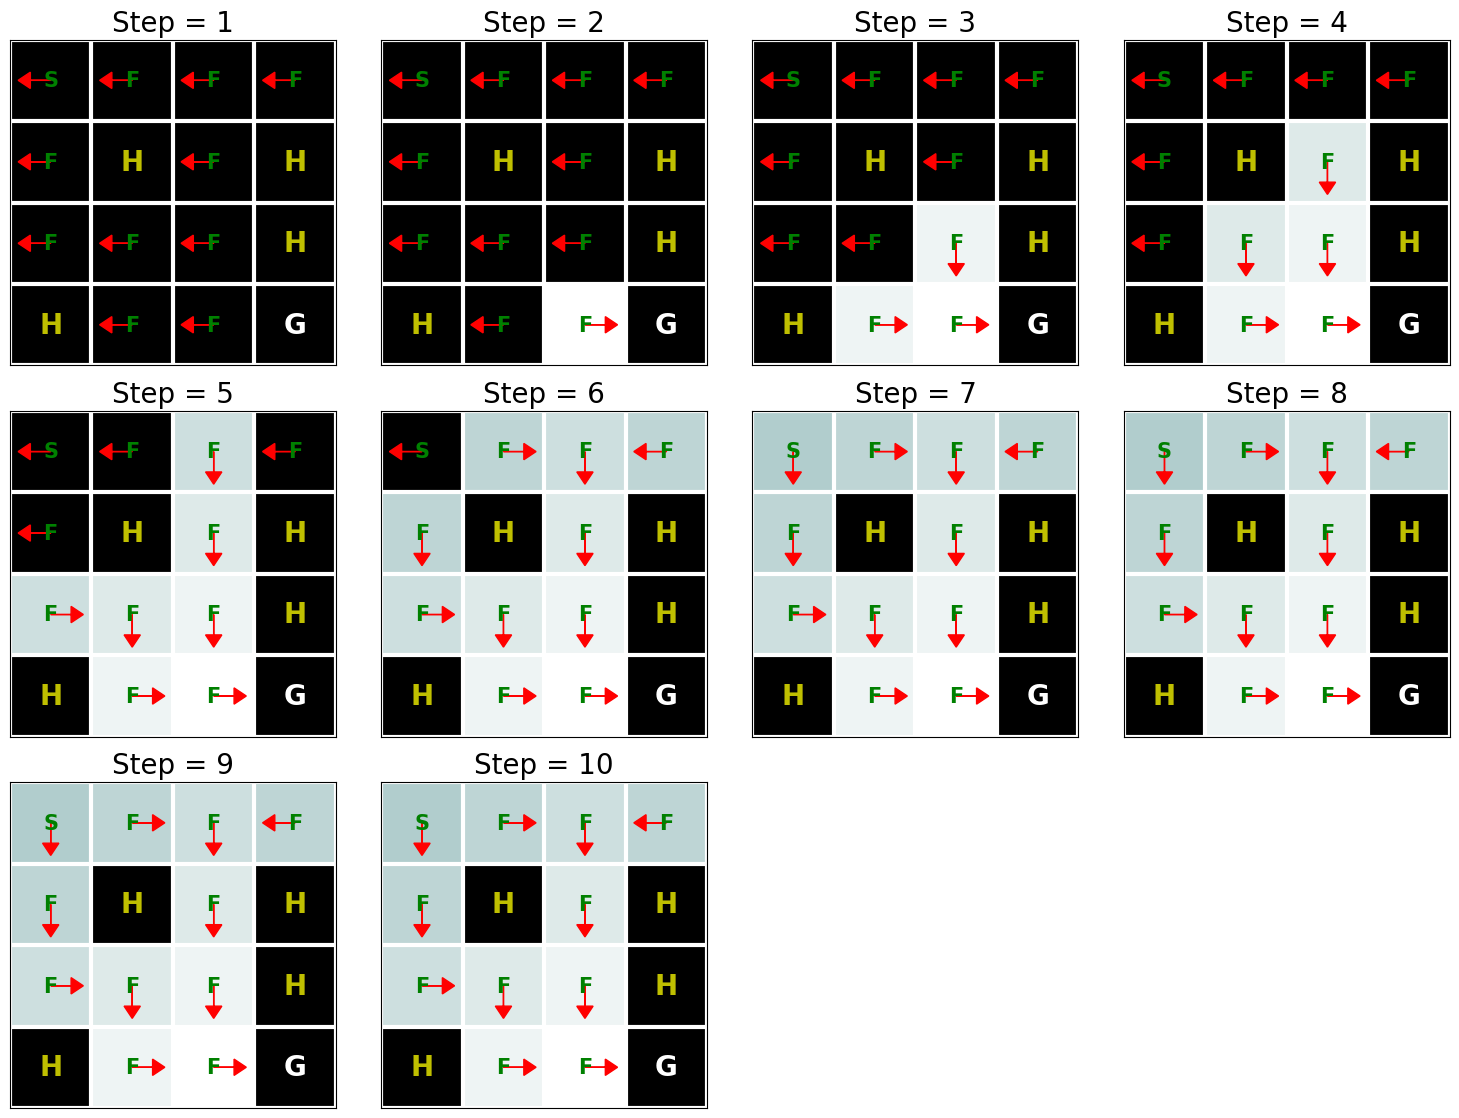

In [2]:
def value_iteration(env_info, gamma, num_iters):
    env_desc = env_info['desc']  # 2D array shows what each item means
    prob_idx = env_info['trans_prob_idx']
    nextstate_idx = env_info['nextstate_idx']
    reward_idx = env_info['reward_idx']
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']
    mdp = env_info['mdp']

    V  = np.zeros((num_iters + 1, num_states))
    Q  = np.zeros((num_iters + 1, num_states, num_actions))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        for s in range(num_states):
            for a in range(num_actions):
                # Calculate \sum_{s'} p(s'\mid s,a) [r + \gamma v_k(s')]
                for pxrds in mdp[(s,a)]:
                    # mdp(s,a): [(p1,next1,r1,d1),(p2,next2,r2,d2),..]
                    pr = pxrds[prob_idx]  # p(s'\mid s,a)
                    nextstate = pxrds[nextstate_idx]  # Next state
                    reward = pxrds[reward_idx]  # Reward
                    Q[k,s,a] += pr * (reward + gamma * V[k - 1, nextstate])
            # Record max value and max action
            V[k,s] = np.max(Q[k,s,:])
            pi[k,s] = np.argmax(Q[k,s,:])
    d2l.show_value_function_progress(env_desc, V[:-1], pi[:-1])

value_iteration(env_info=env_info, gamma=gamma, num_iters=num_iters)

The above pictures show the policy (the arrow indicates the action) and value function (the change in color shows how the value function changes over time from the initial value shown by dark color to the optimal value shown by light colors.). As we see, Value Iteration finds the optimal value function after 10 iterations and the goal state (G) can be reached starting from any state as long as it is not an H cell. Another interesting aspect of the implementation is that in addition to finding the optimal value function, we also automatically found the optimal policy $\pi^*$ corresponding to this value function.


## Summary
The main idea behind the Value Iteration algorithm is to use the principle of dynamic programming to find the optimal average return obtained from a given state. Note that implementing the Value Iteration algorithm requires that we know the Markov decision process (MDP), e.g., the transition and reward functions, completely.


## Exercises

1. Try increasing the grid size to $8 \times 8$. Compared with $4 \times 4$ grid, how many iterations does it take to find the optimal value function?
1. What is the computational complexity of the Value Iteration algorithm?
1. Run the Value Iteration algorithm again with $\gamma$ (i.e. "gamma" in the above code) when it equals to $0$, $0.5$, and $1$ and analyze its results. 
1. How does the value of $\gamma$ affect the number of iterations taken by Value Iteration to converge? What happens when $\gamma=1$?


[Discussions](https://discuss.d2l.ai/t/12005)
